# Time Series

#### 1.engineer features to model the major time series components (trends, seasons, and cycles),
#### 2.visualize time series with many kinds of time series plots,
#### 3.create forecasting hybrids that combine the strengths of complementary models, and
#### 4.adapt machine learning methods to a variety of forecasting tasks.

##### The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

### Time-step features
##### There are two kinds of features unique to time series: time-step features and lag features.

##### Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

##### Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured. In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.


### Lag features
##### To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

##### More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

### utils

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


# def make_lag_features(y, lags):
#     name = 'lag' if lags > 0 else 'lead'
#     steps = range(1, lags + 1) if lags > 0 else range(-1, lags - 1, -1)
#     return pd.concat(
#         [y.shift(i, freq='infer') for i in steps],
#         axis=1,
#         join='outer',
#         keys=[f'{y.name}_{name}_{i if lags > 0 else -i}' for i in steps],
#     )




class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None

    def fit(self, X_1, X_2, y, stack_cols=None):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=y.columns,
        )
        # Compute residuals
        y_resid = y - y_fit + y_fit.mean(axis=0)
        y_resid = y_resid.stack(stack_cols).squeeze()  # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        self.stack_cols = stack_cols

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred -= y_pred.mean(axis=0)
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack(self.stack_cols)



def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


def create_multistep_example(n, steps, lags, lead_time=1):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                     .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data


def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

# Linear Regression With Time Series

In [ ]:
import os 
from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

In [2]:
pwd

'/rapids/notebooks/my_code/TimeSeries'

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [5]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex1 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

# book_sales = pd.read_csv(
#     data_dir / 'book_sales.csv',
#     index_col='Date',
#     parse_dates=['Date'],
# ).drop('Paperback', axis=1)

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date']
)



book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'store_sales.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

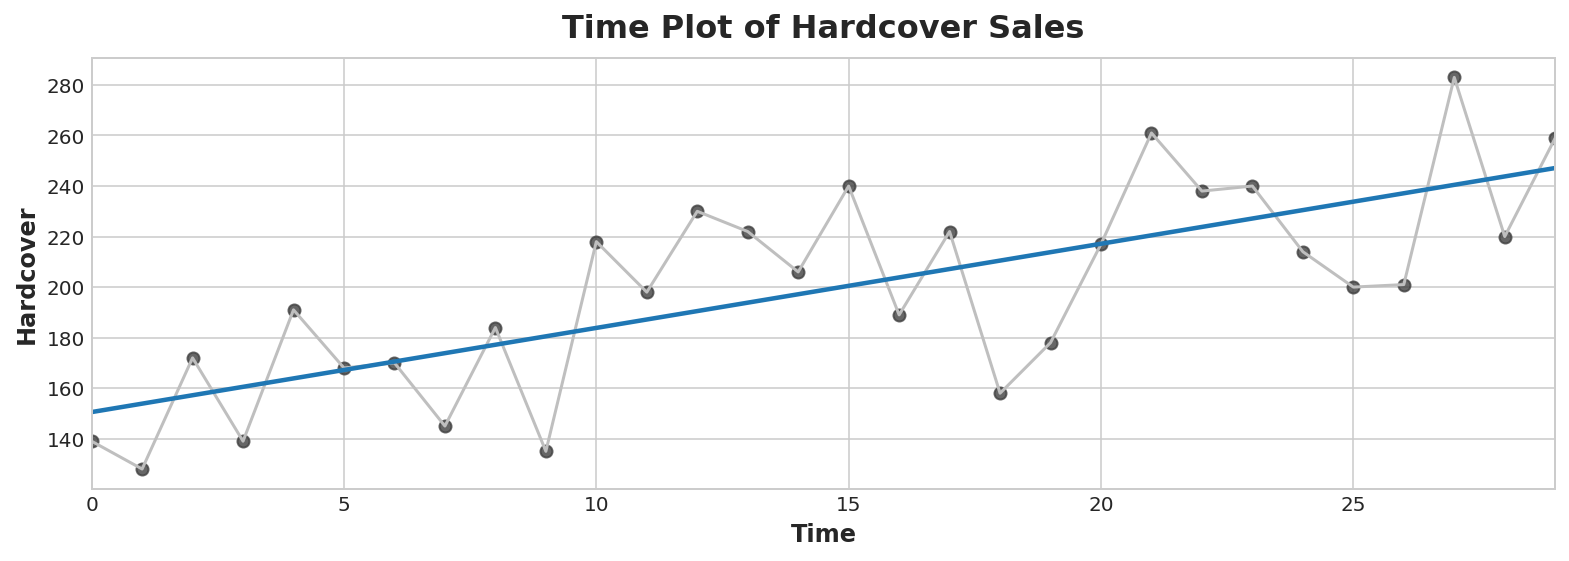

In [19]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');


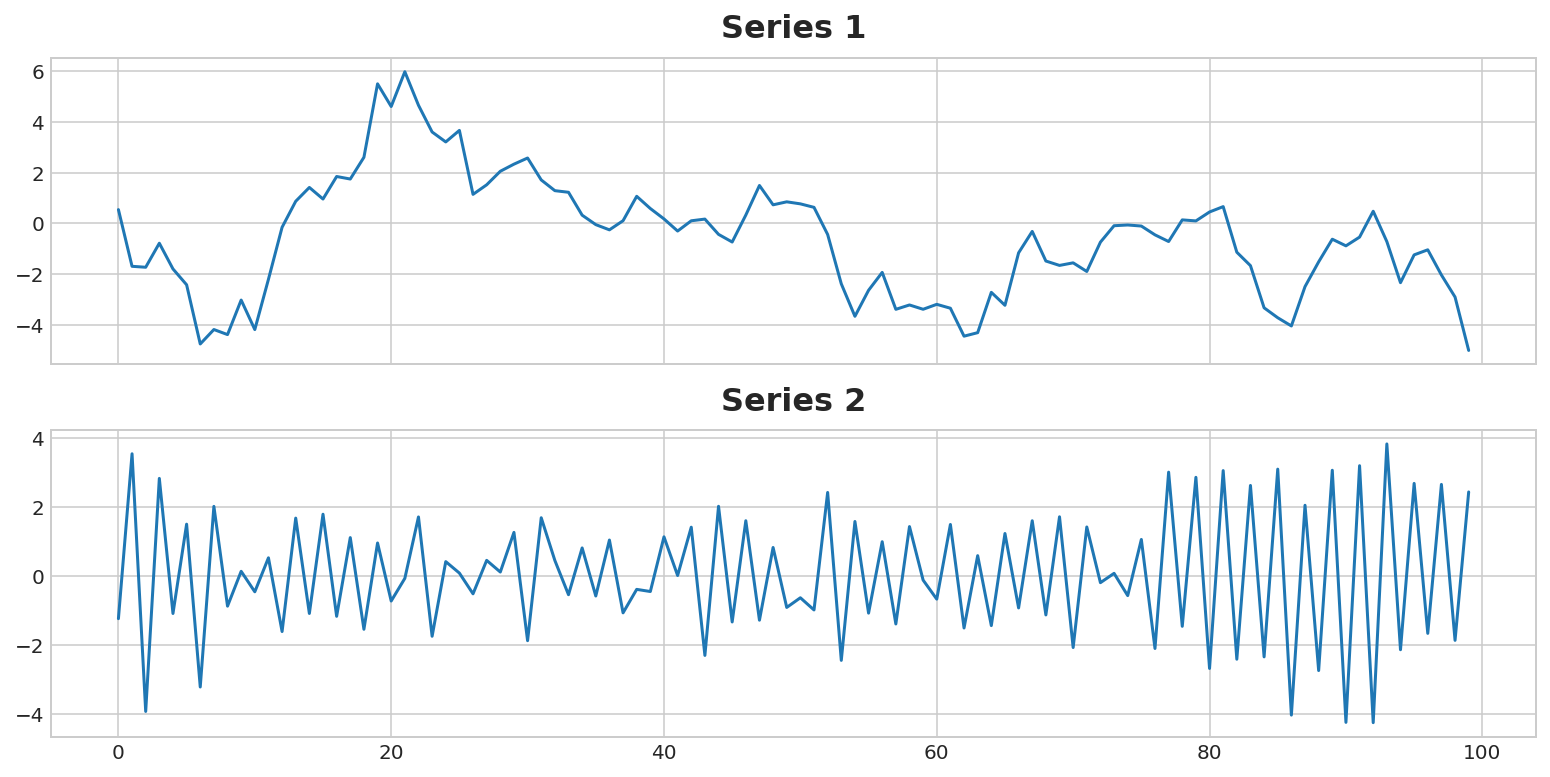

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

#### Fit a time-step feature

In [23]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))

df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:,['time']]  # features
y = df.loc[:,'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


In [25]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

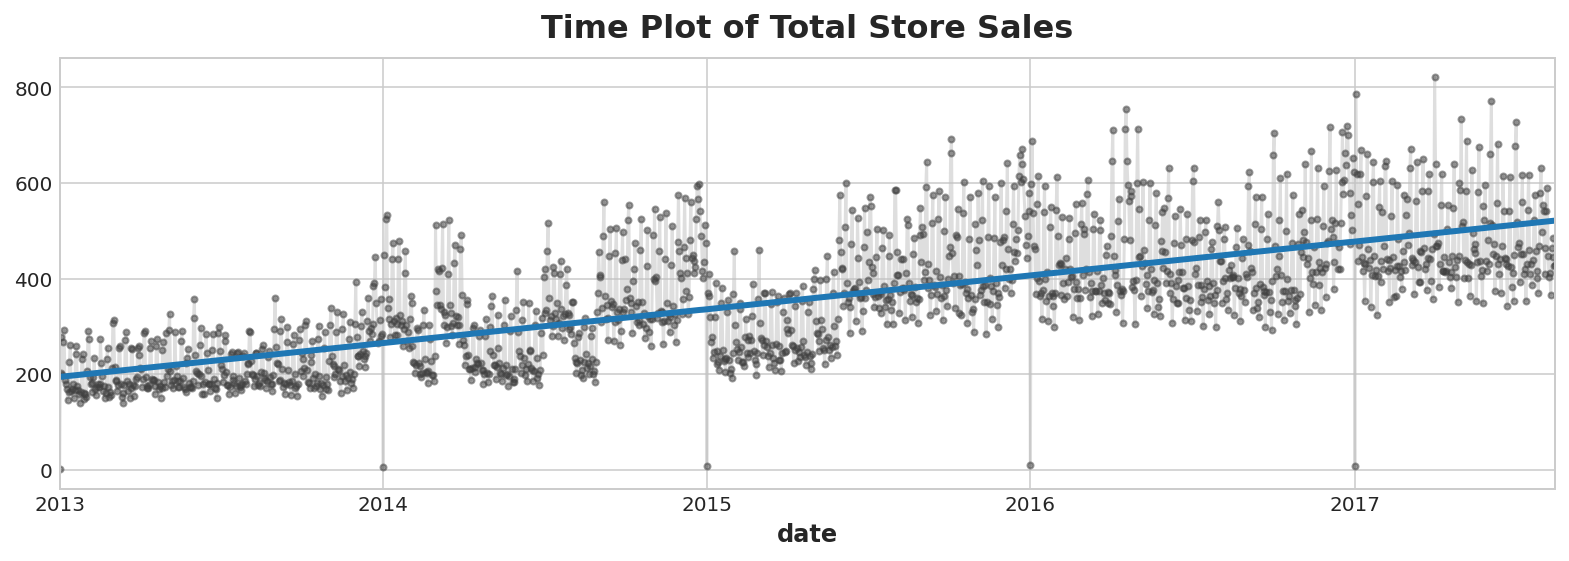

In [26]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

#### Fit a lag feature to Store Sales

In [27]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression().fit(X,y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index = X.index)

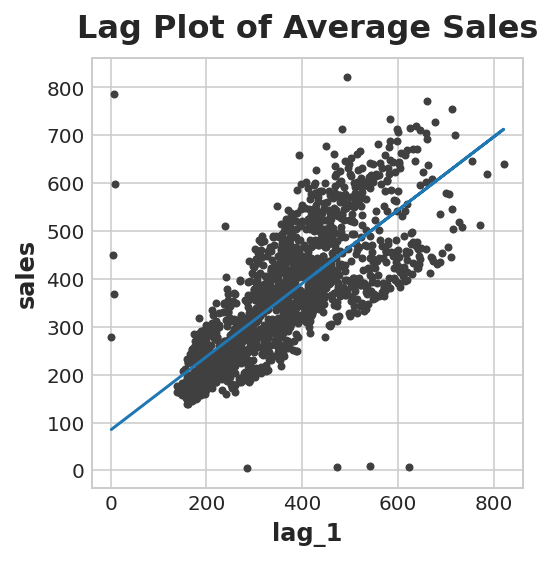

In [28]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

## Trend
#### Model long-term changes with moving averages and the time dummy.


#### What is Trend?
###### The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

#### Moving Average Plots
##### To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

#### Engineering Trend
##### Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend
##### We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us. linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

In [29]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex2 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [ ]:
# retail_sales.to_csv("us-retail-sales.csv")
# store_sales.to_csv('train.csv')
# import os
# os.chdir('/kaggle/working')
# from IPython.display import FileLink, FileLinks
# FileLinks('.') #lists all downloadable files on server

#### Determine trend with a moving average plot

###### The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States. Run the next cell to see a plot of the *Food and Beverage* series.

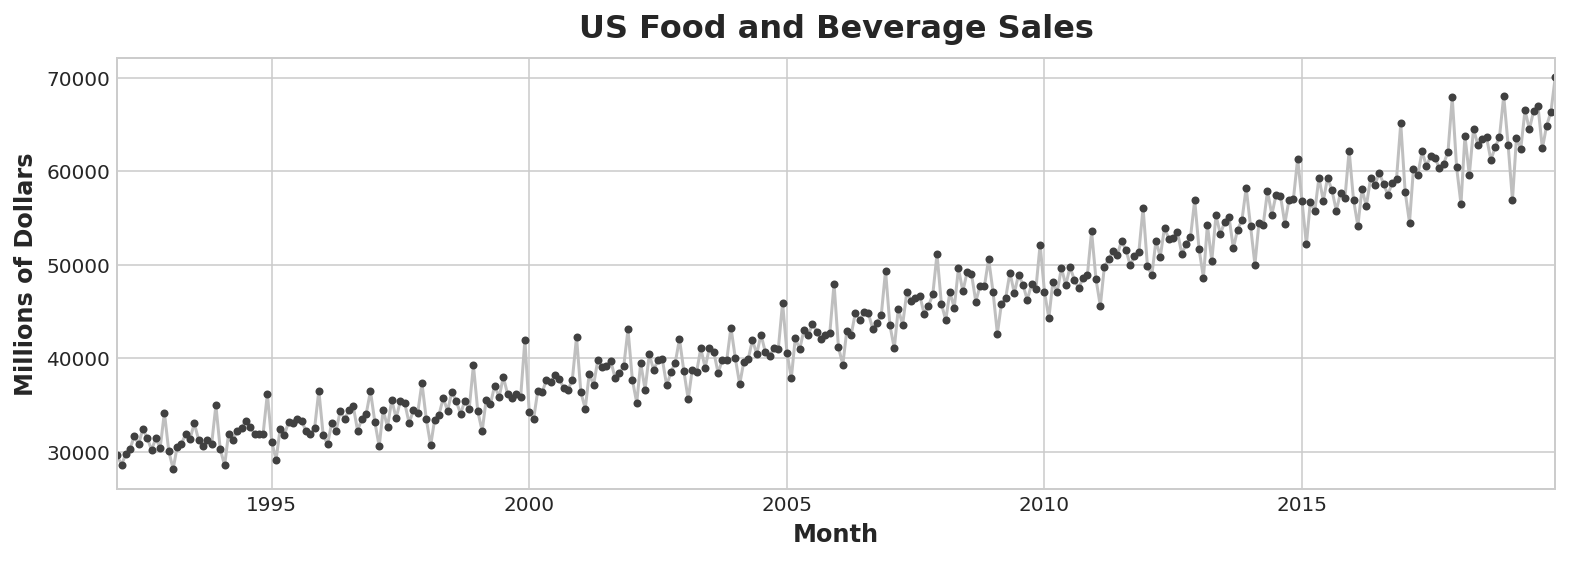

In [30]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

###### Now make a moving average plot to estimate the trend for this series.

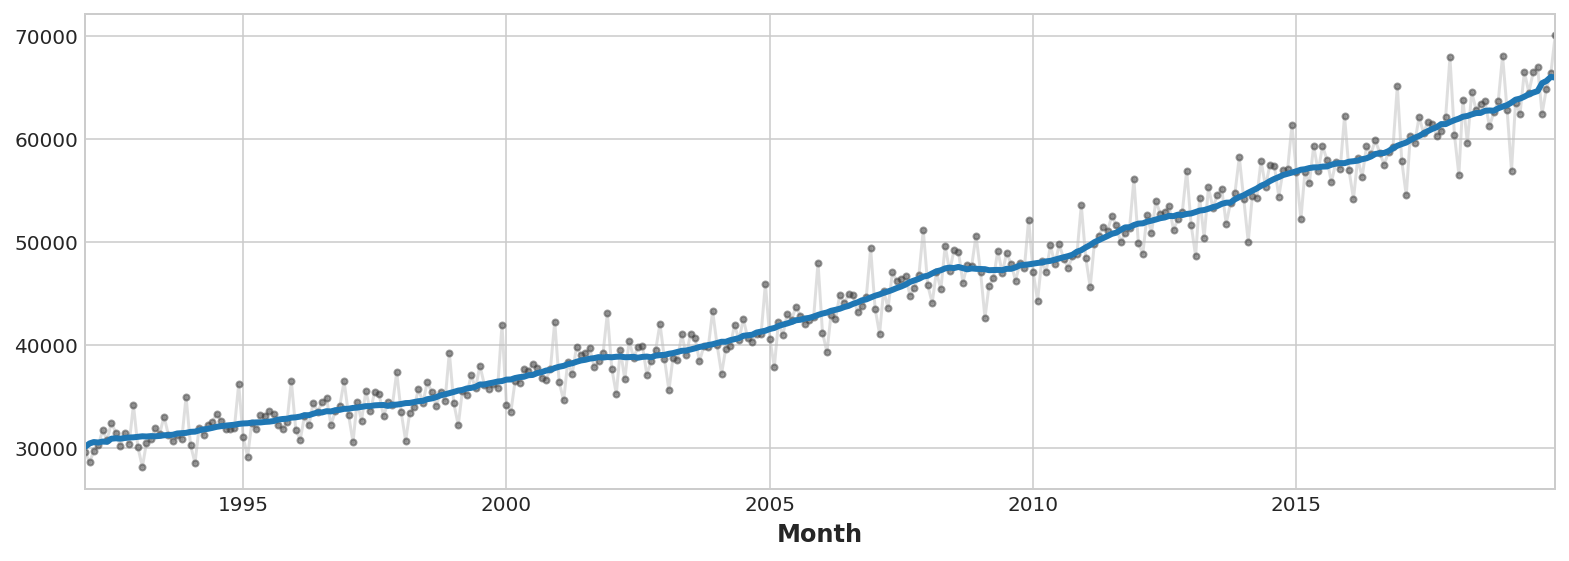

In [32]:
# Add methods to `food_sales` to compute a moving
# average with appropriate parameters for trend estimation.
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

#### Identify trend

###### What order polynomial trend might be appropriate for the *Food and Beverage Sales* series? Can you think of a non-polynomial curve that might work even better?

###### The upwards bend in the trend suggests an order 2 (quadratic) polynomial might be appropriate.

###### In economic time series, the growth rate in Food and Beverage Sales is best expressed as a percent change. Percent change can often be modeled using an exponential curve.

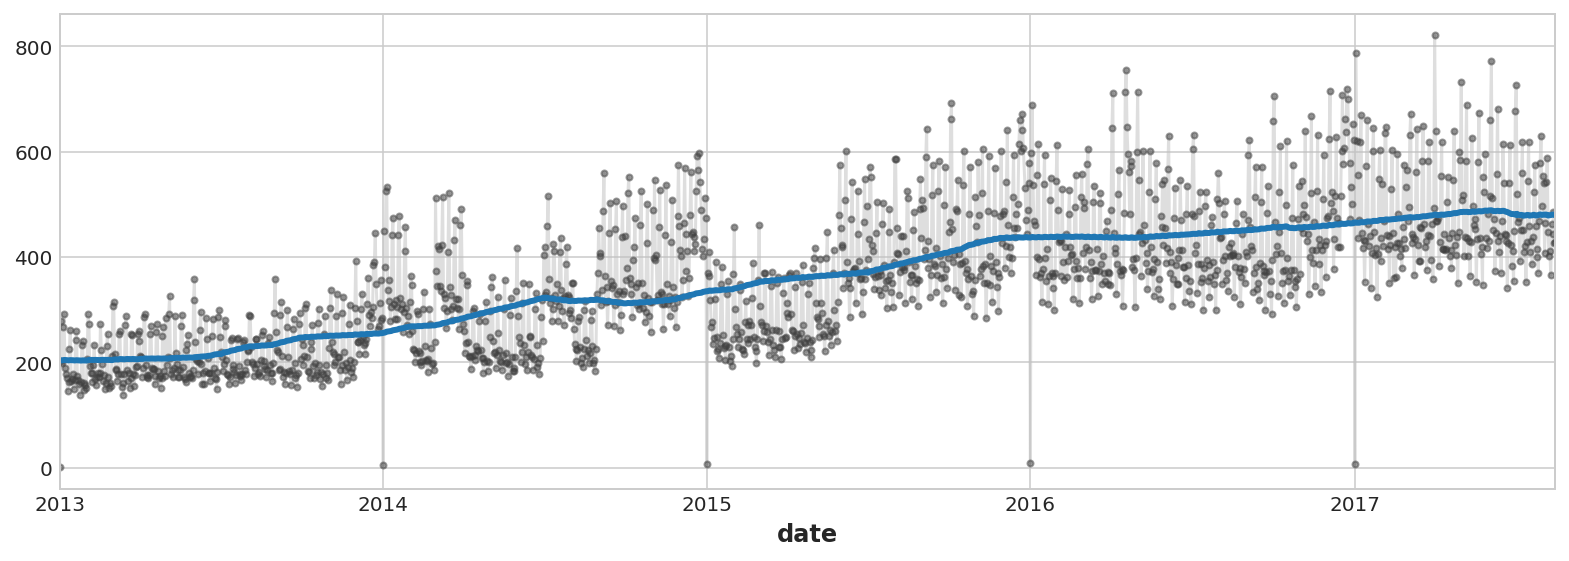

In [33]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

#### Create a Trend Feature

###### Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [47]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# Instantiate `DeterministicProcess` with arguments
# # appropriate for a quadratic trend model
# dp = ____

# Create the feature set for the dates given in y.index
# X = ____

# Create features for a 90-day forecast.
# X_fore = ____


dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

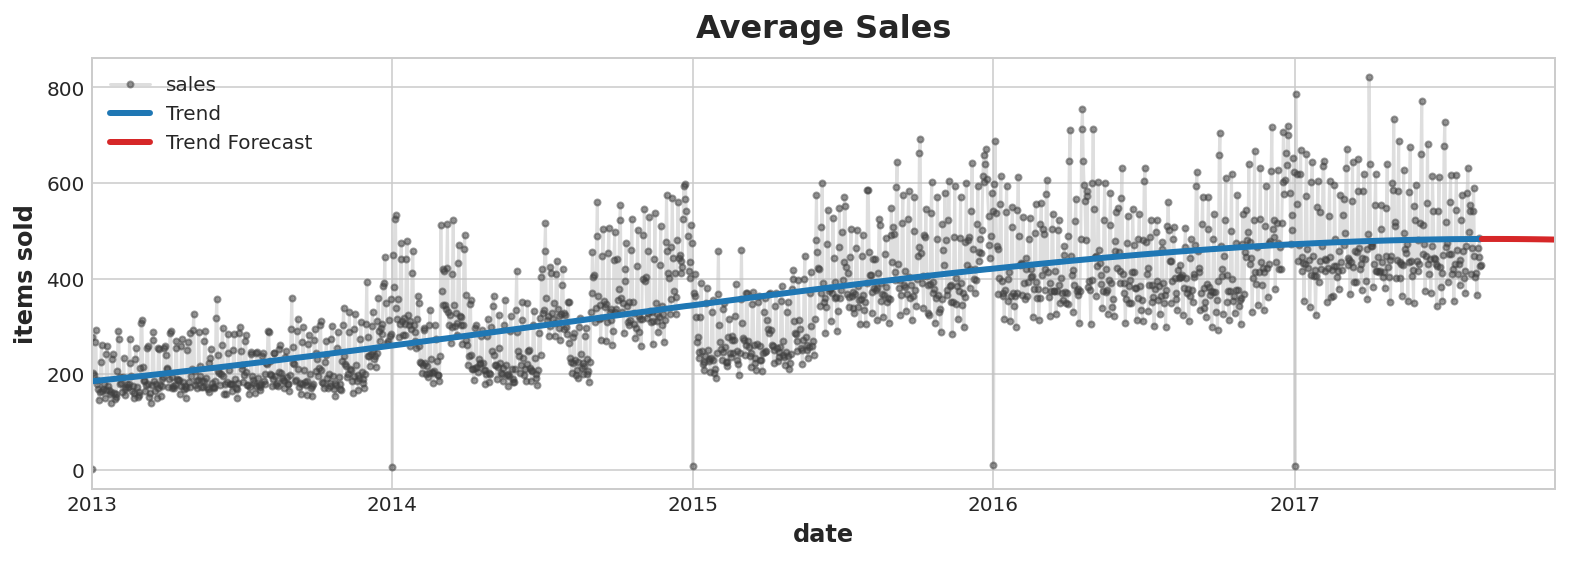

In [48]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

###### One way to fit more complicated trends is to increase the order of the polynomial you use. To get a better fit to the somewhat complicated trend in Store Sales, we could try using an order 11 polynomial.

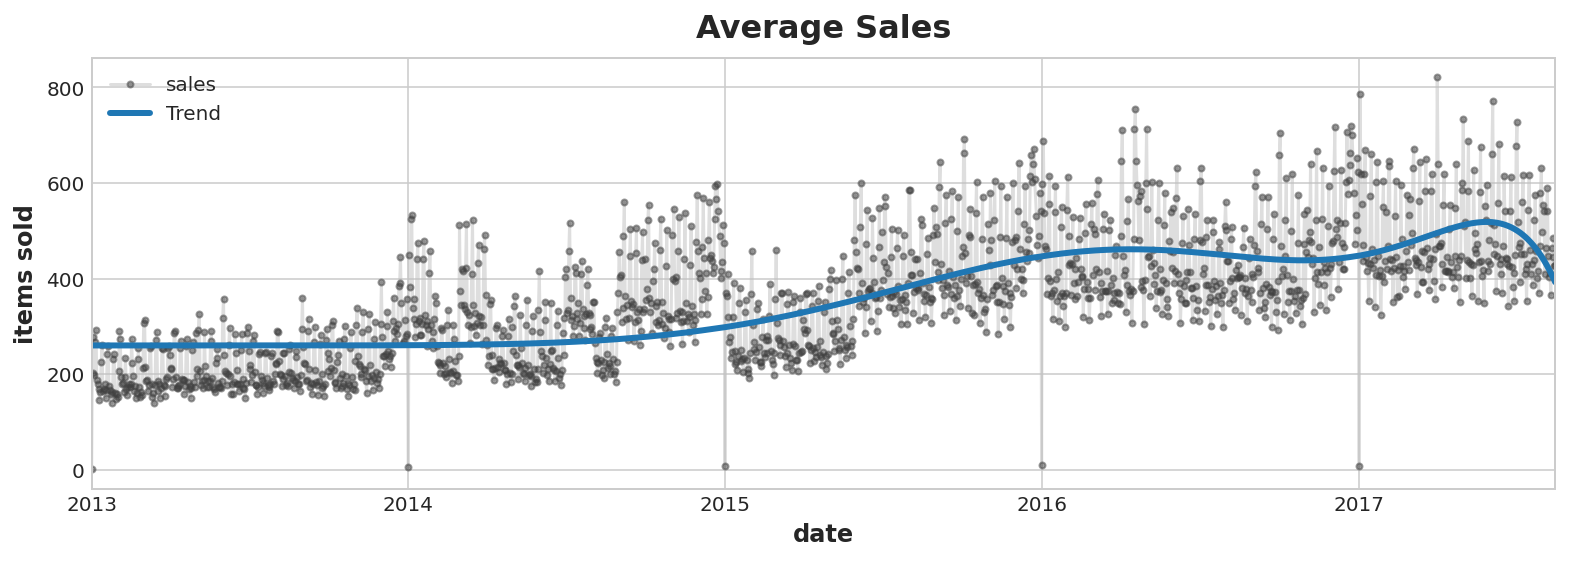

In [49]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

#### Understand risks of forecasting with high-order polynomials

###### High-order polynomials are generally not well-suited to forecasting
###### An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable
###### the rate of change of a term like t ** 11 over a long period of time

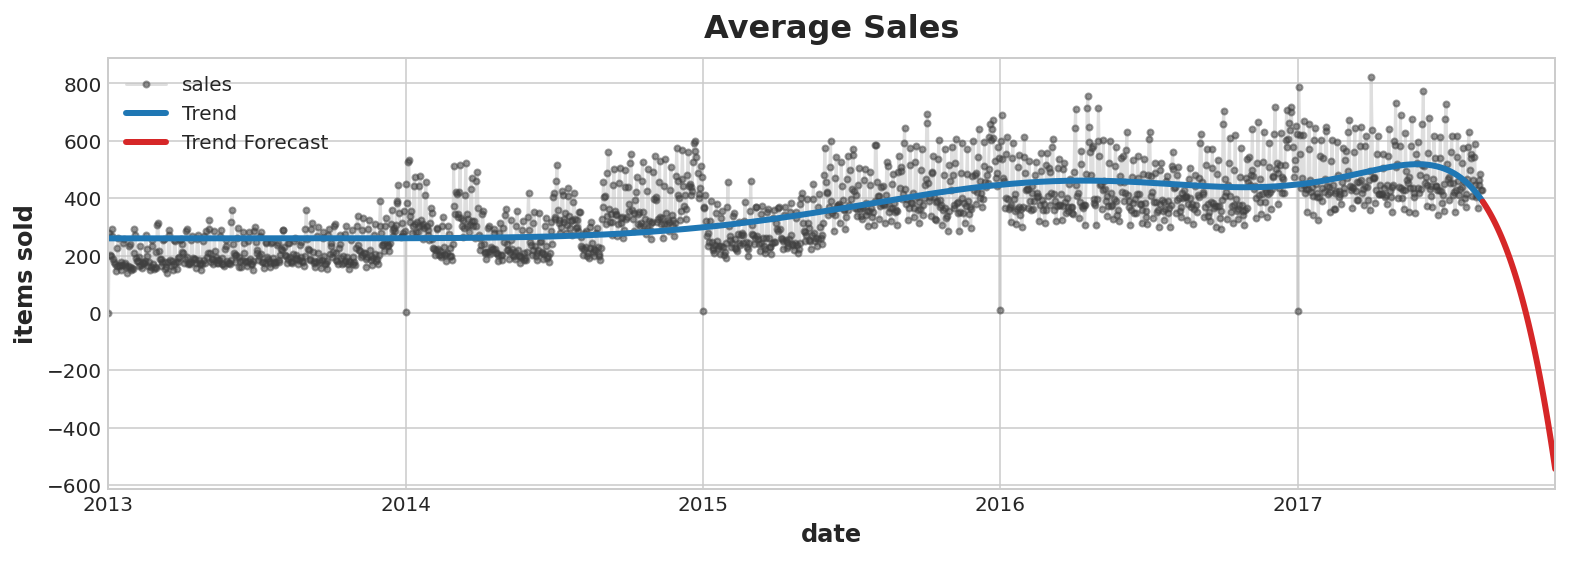

In [50]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

#### Fit trend with splines

###### *Splines* are a nice alternative to polynomials when you want to fit a trend. The *Multivariate Adaptive Regression Splines* (MARS) algorithm in the `pyearth` library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.

In [ ]:
# conda install -c conda-forge sklearn-contrib-py-earth

/opt/conda/envs/rapids/lib/python3.7/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/conda/envs/rapids/lib/python3.7/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


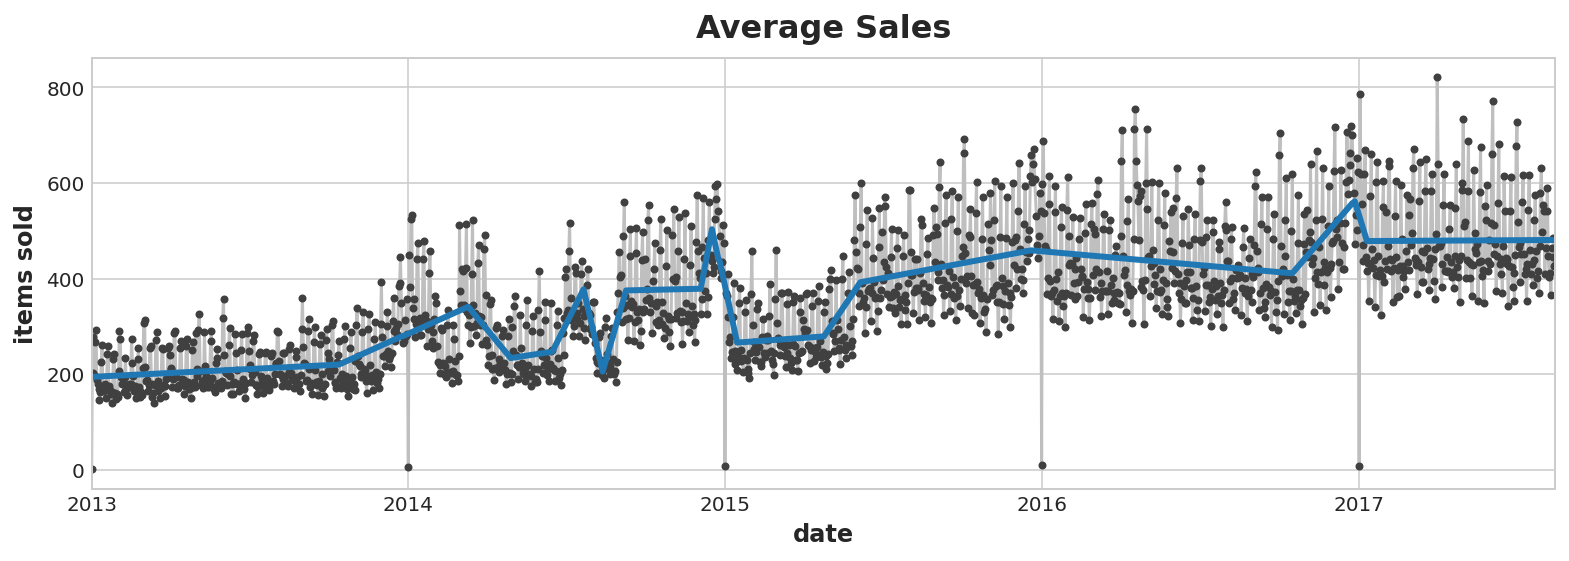

In [57]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

###### Forecasting complicated trends like this will typically be difficult (if not impossible). With historical data, however, you can use splines to isolate other patterns in a time series by detrending

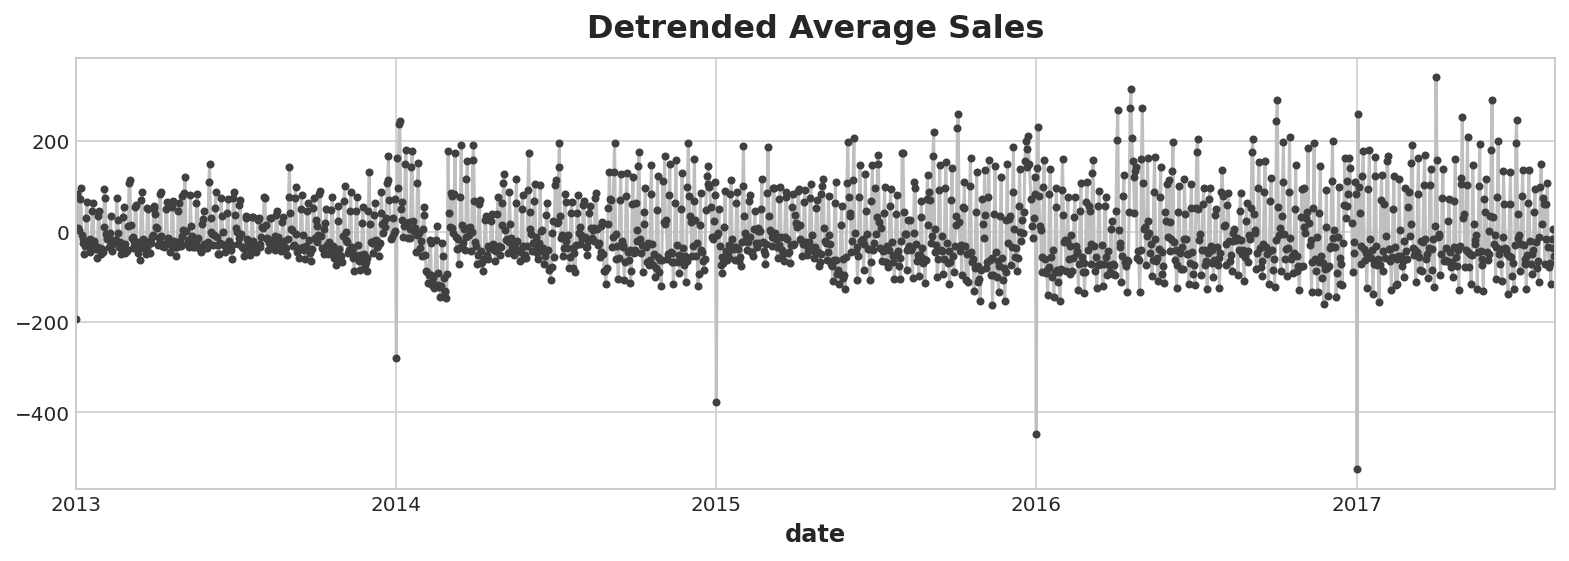

In [58]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");

## Seasonality
#### Create indicators and Fourier features to capture periodic change.

### What is Seasonality?
###### We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

###### There are two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.


### Seasonal Plots and Seasonal Indicators
###### Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

###### A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.

#### Seasonal indicators
###### Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

###### By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the Trigonometry series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators) Adding seasonal indicators to the training data helps models distinguish means within a seasonal period. The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of 1 (On). Linear regression learns a baseline value 2379 for Mon and then adjusts by the value of whichever indicator is On for that day; the rest are 0 and vanish.


#### Fourier Features and the Periodogram
###### The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

###### Let's take a look at a plot for the annual season in Trigonometry. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

##### Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on. If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series.Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.


#### Choosing Fourier features with the Periodogram
##### How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).From left to right, the periodogram drops off after Quarterly, four times a year. That was why we chose four Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.


#### Computing Fourier features (optional)
##### Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from statsmodels for our applications, however.)

In [59]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
# fourier_features(y, freq=365.25, order=4)

In [60]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings
# from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [62]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

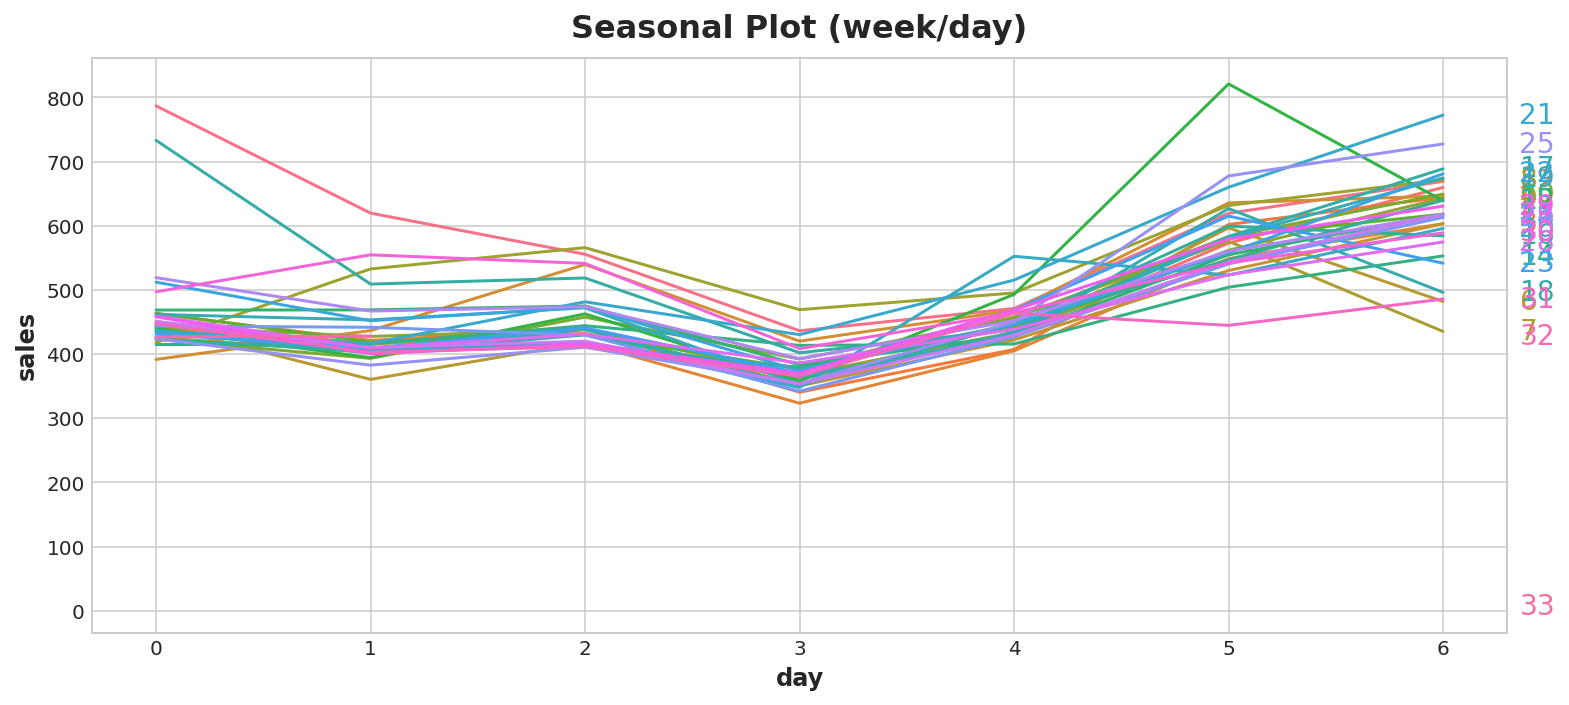

In [63]:
# Examine the following seasonal plot:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

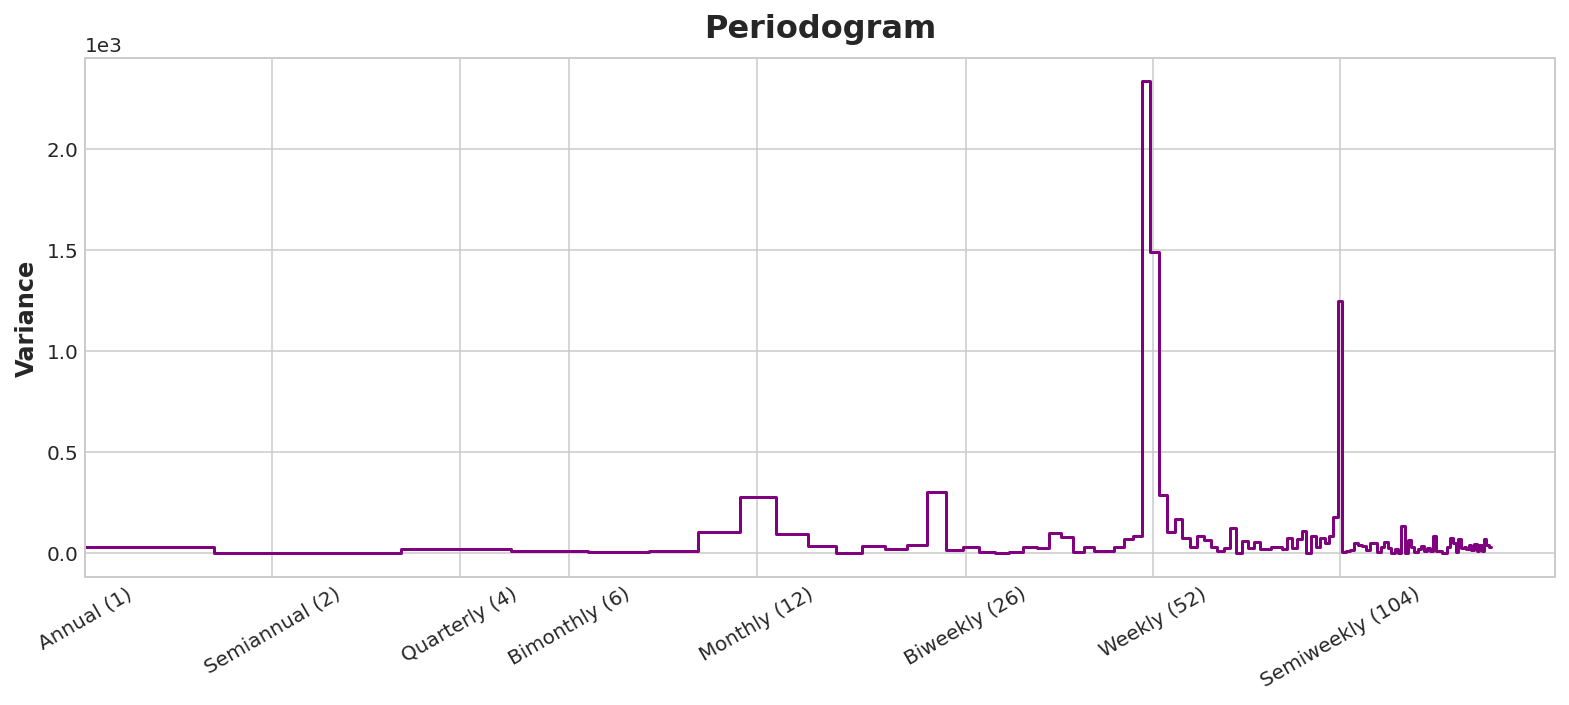

In [64]:
# And also the periodogram:
plot_periodogram(average_sales);

#### Determine seasonality
###### Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

##### Create seasonal features

###### Use `DeterministicProcess` and `CalendarFourier` to create:
###### - indicators for weekly seasons and
###### - Fourier features of order 4 for monthly seasons.

In [ ]:
# from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

# dp = DeterministicProcess(
#     index=tunnel.index,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=1,                     # trend (order 1 means linear)
#     seasonal=True,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )

# X = dp.in_sample()  # create features for dates in tunnel.index

In [65]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

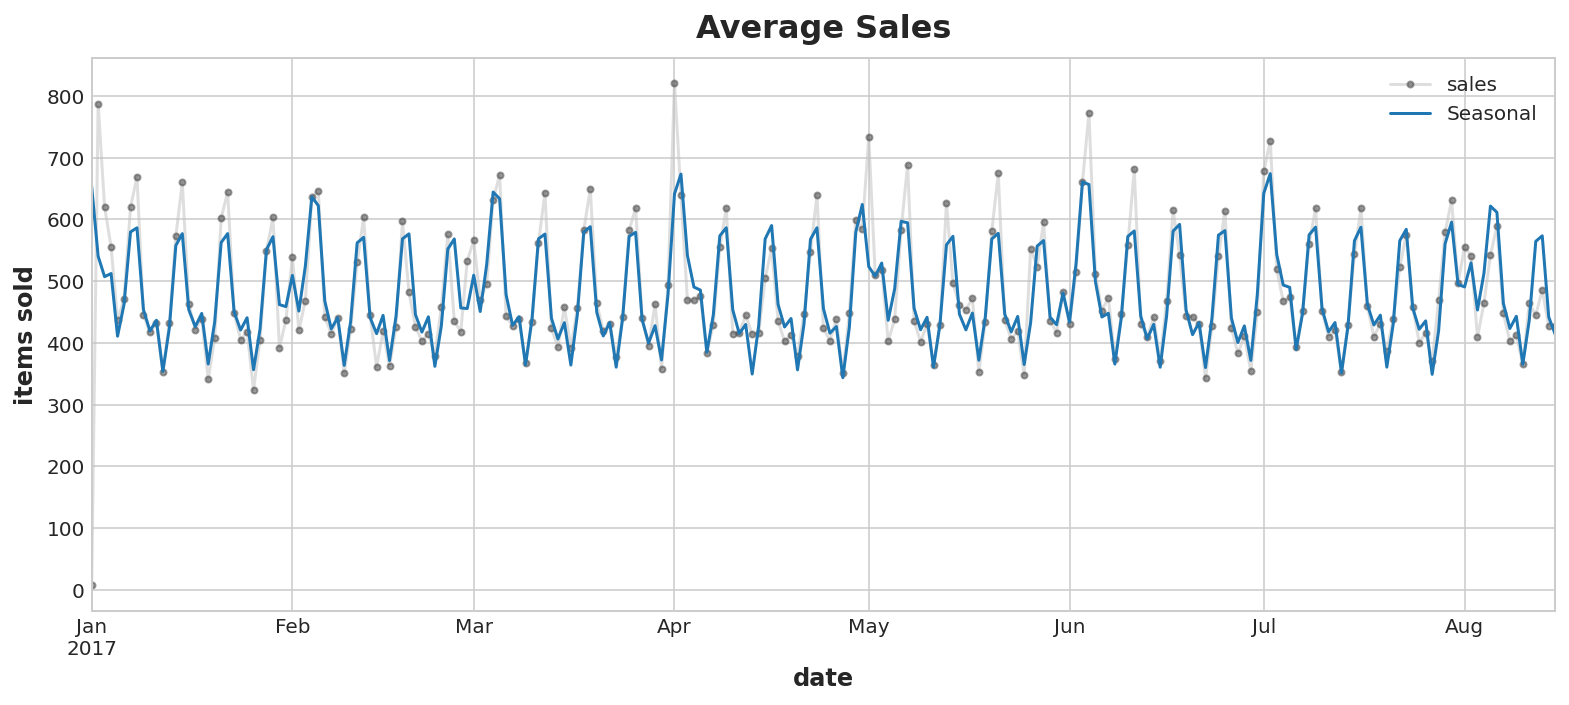

In [66]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

###### Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

###### Look at the periodogram of the deseasonalized series.

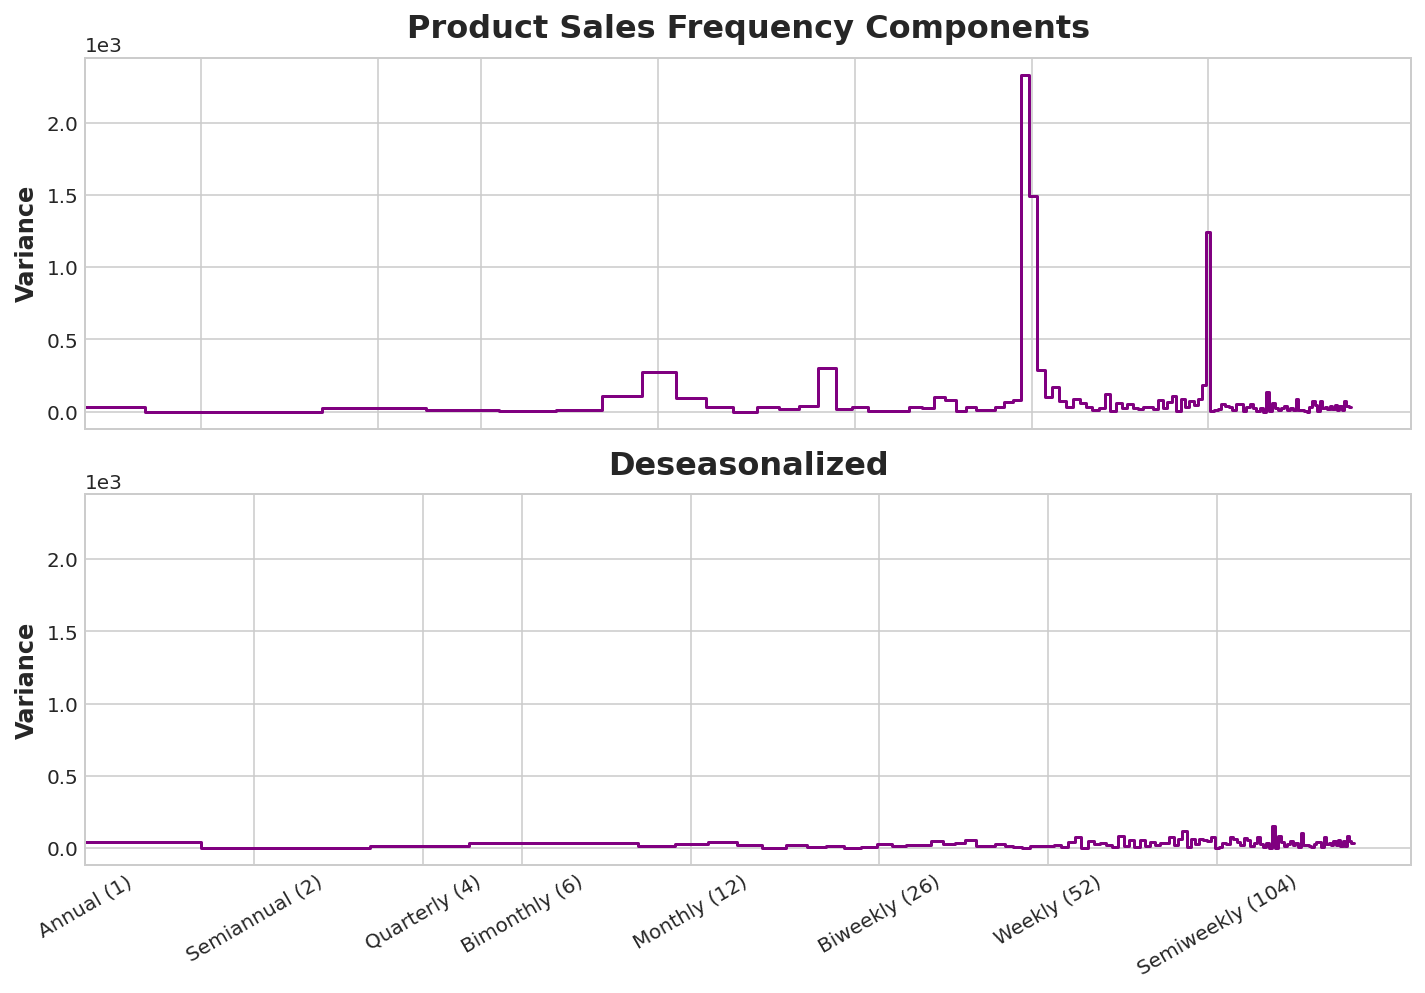

In [67]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

#### Check for remaining seasonality

###### Based on these periodograms, how effectively does it appear your model captured the seasonality in *Average Sales*? Does the periodogram agree with the time plot of the deseasonalized series?
###### The Store Sales dataset includes a table of Ecuadorian holidays.

In [68]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

###### From a plot of the deseasonalized *Average Sales*, it appears these holidays could have some predictive power.

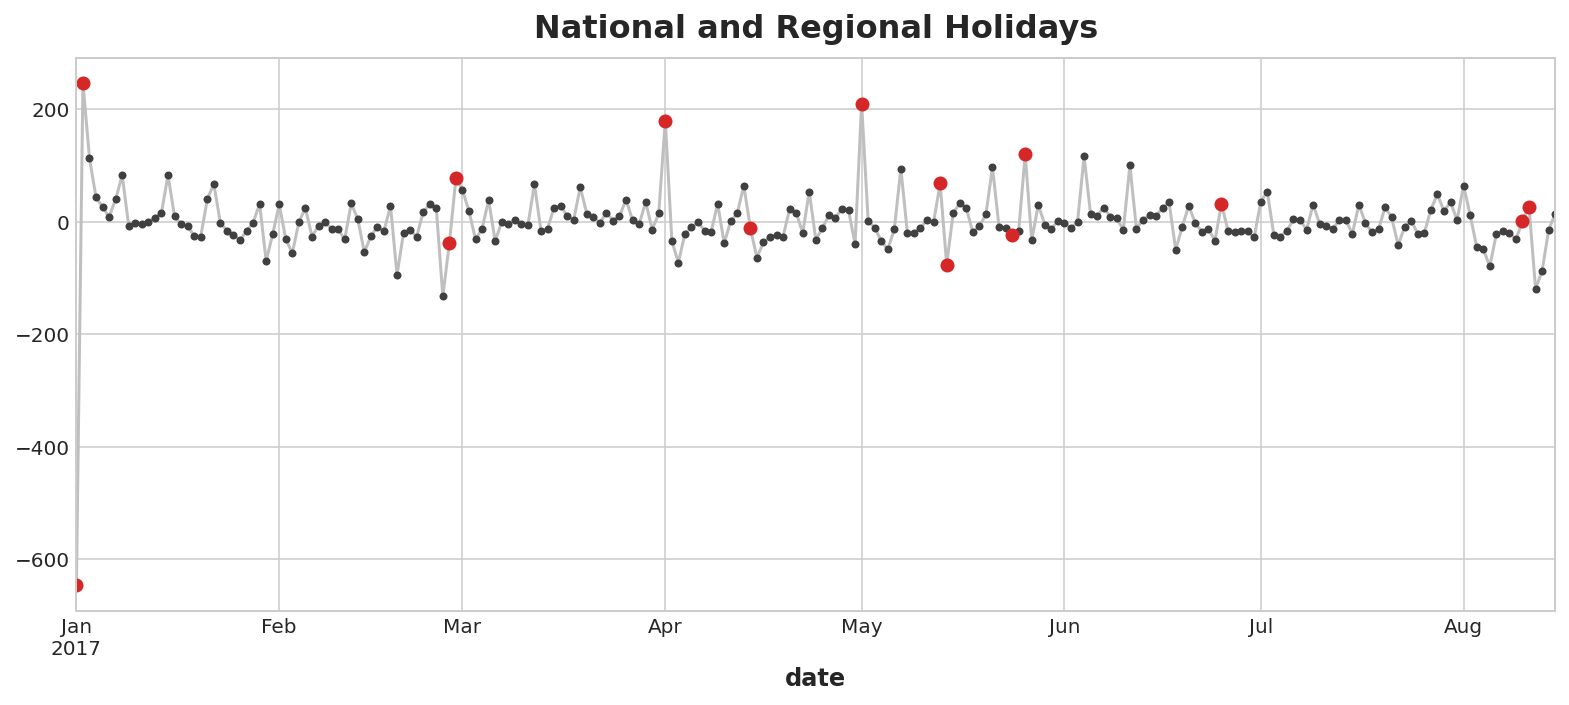

In [69]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

#### Create holiday features

###### What kind of features could you create to help your model make use of this information? Code your answer in the next cell. (Scikit-learn and Pandas both have utilities that should make this easy.

In [72]:
# Scikit-learn solution
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False)

# X_holidays = pd.DataFrame(
#     ohe.fit_transform(holidays),
#     index=holidays.index,
#     columns=holidays.description.unique(),
# )


# Pandas solution
X_holidays = pd.get_dummies(holidays)


# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)


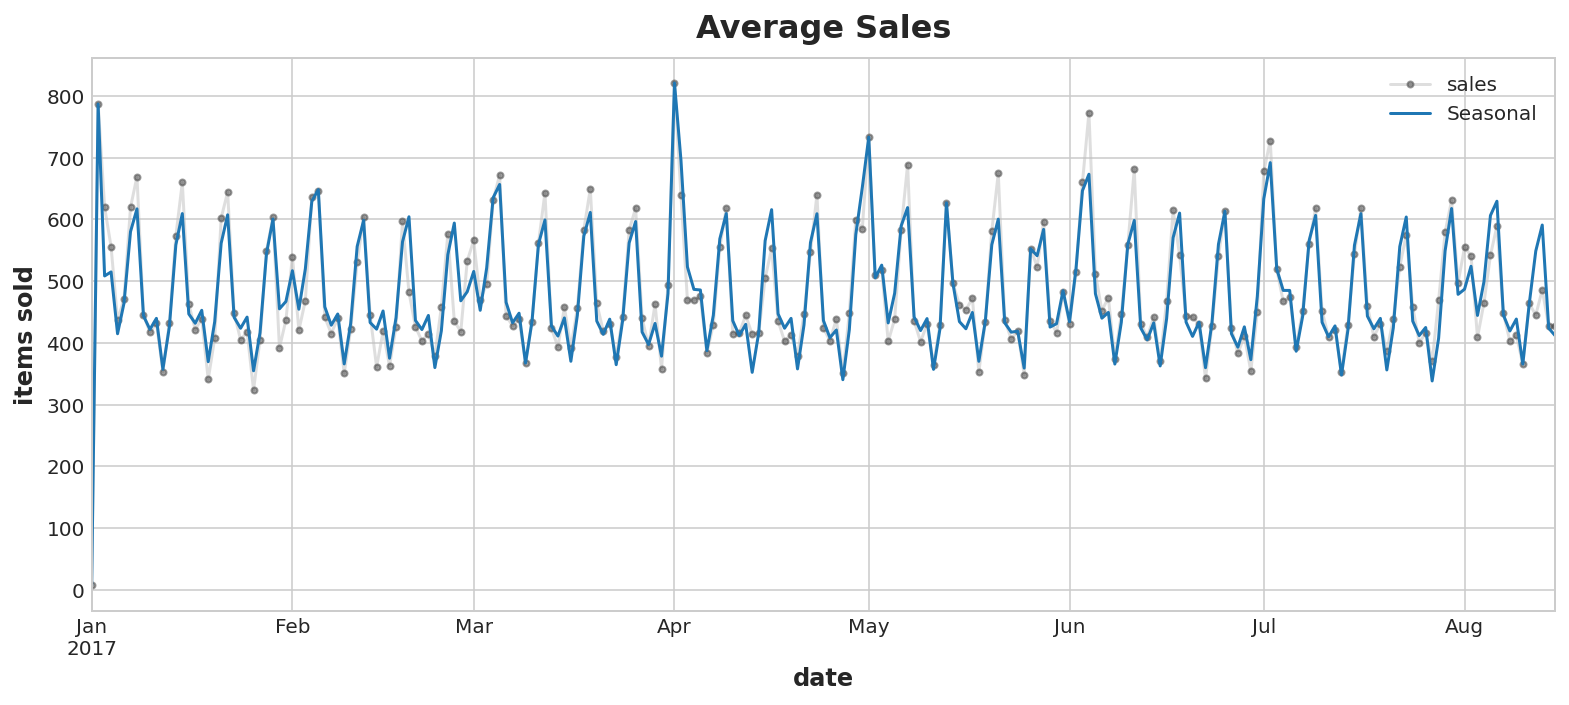

In [73]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

##### seasonal model of  the full *Store Sales* dataset with all 1800 time series.

In [74]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

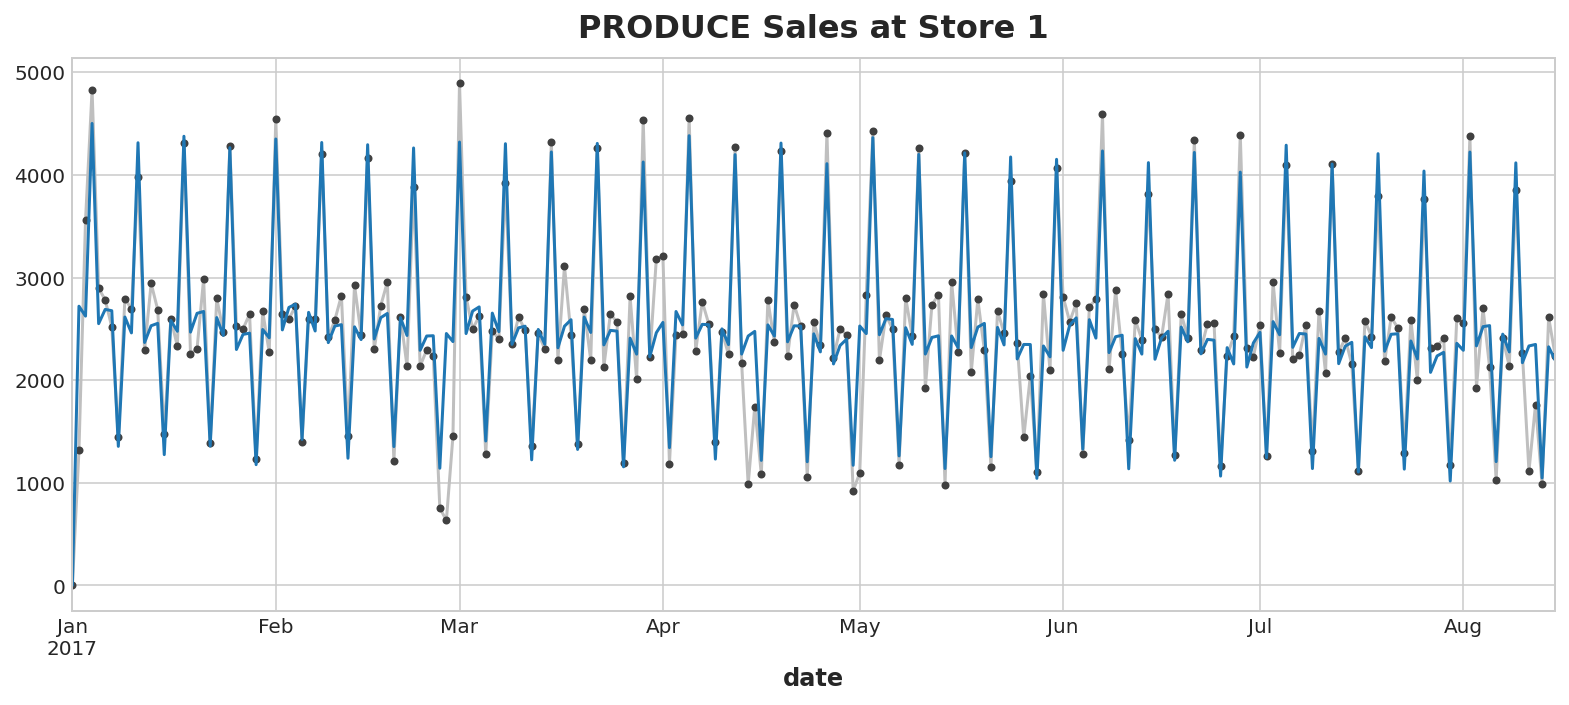

In [76]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

###### Finally, this cell loads the test data, creates a feature set for the forecast period, and then creates the submission file `submission.csv`.

In [77]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

## Time Series as Features
#### Predict the future from the past with a lag embedding.

###### In earlier lessons, we investigated properties of time series that were most easily modeled as time dependent properties, that is, with features we could derive directly from the time index. Some time series properties, however, can only be modeled as serially dependent properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear. With trend and seasonality, we trained models to fit curves to plots like those on the left in the figure above -- the models were learning time dependence. The goal is to train models to fit curves to plots like those on the right -- we want them to learn serial dependence.


#### Cycles
###### One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior. What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

#### Lagged Series and Lag Plots
###### To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time. By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use y_lag_1 and y_lag_2 as features to predict the target y. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.


#### Lag plots¶
###### A lag plot of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. We can see from this lag plot of US Unemployment that there is a strong and apparently linear relationship between the current unemployment rate and past rates. The most commonly used measure of serial dependence is known as autocorrelation, which is simply the correlation a time series has with one of its lags. US Unemployment has an autocorrelation of 0.99 at lag 1, 0.98 at lag 2, and so on.

#### Choosing lags
###### When choosing lags to use as features, it generally won't be useful to include every lag with a large autocorrelation. In US Unemployment, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1. The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for US Unemployment. (Lag 11 is likely a false positive.) A plot like that above is known as a correlogram. The correlogram is for lag features essentially what the periodogram is for Fourier features. Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of linear dependence. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like mutual information) when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation. Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.

In [78]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings
# from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

###### Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of magazines, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in magazine sales using lag features.

###### Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize Magazine Sales. We'll store the result in a variable y_deseason.

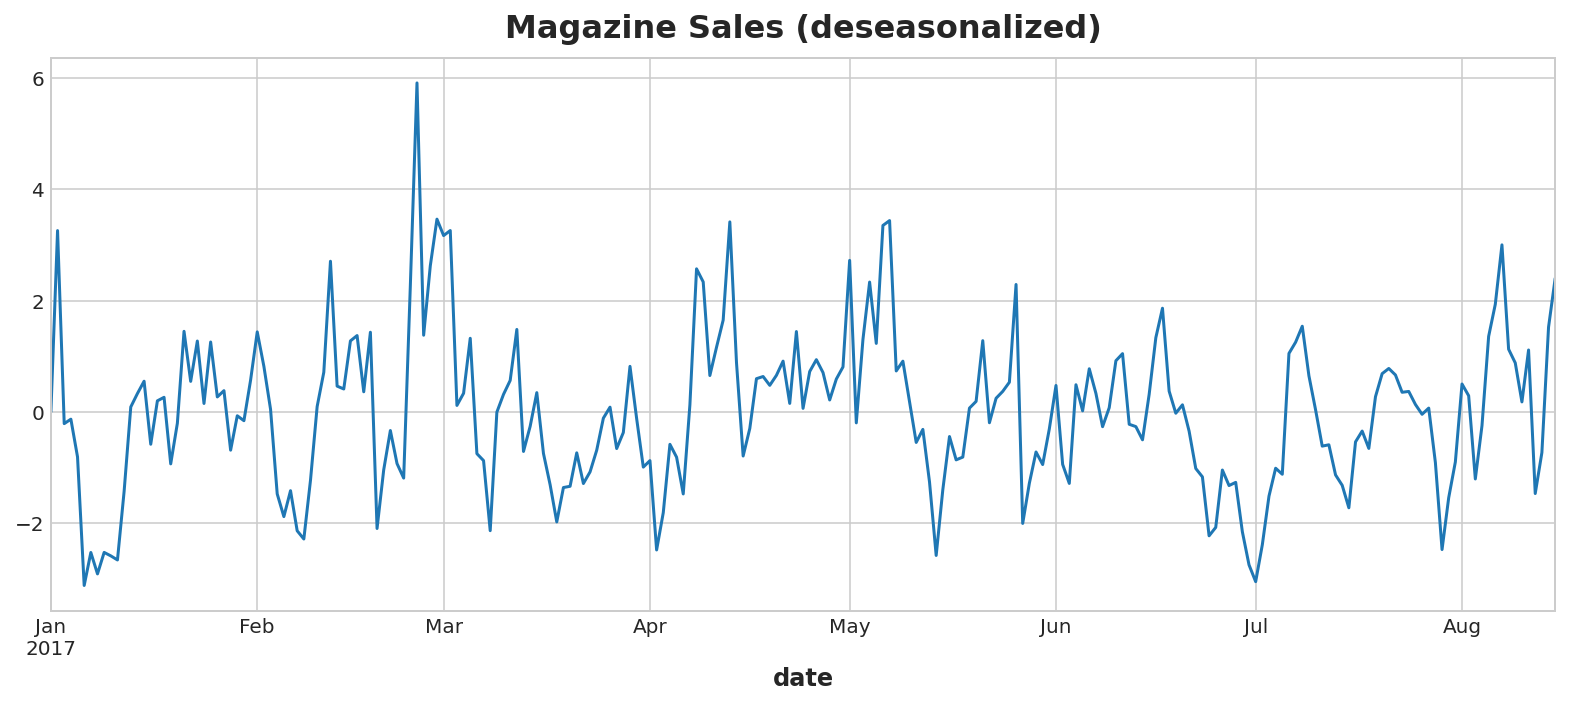

In [79]:
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");

###### Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

#### Plotting cycles

###### Create a seven-day moving average from `y`, the series of magazine sales. Use a centered window, but don't set the `min_periods` argument.

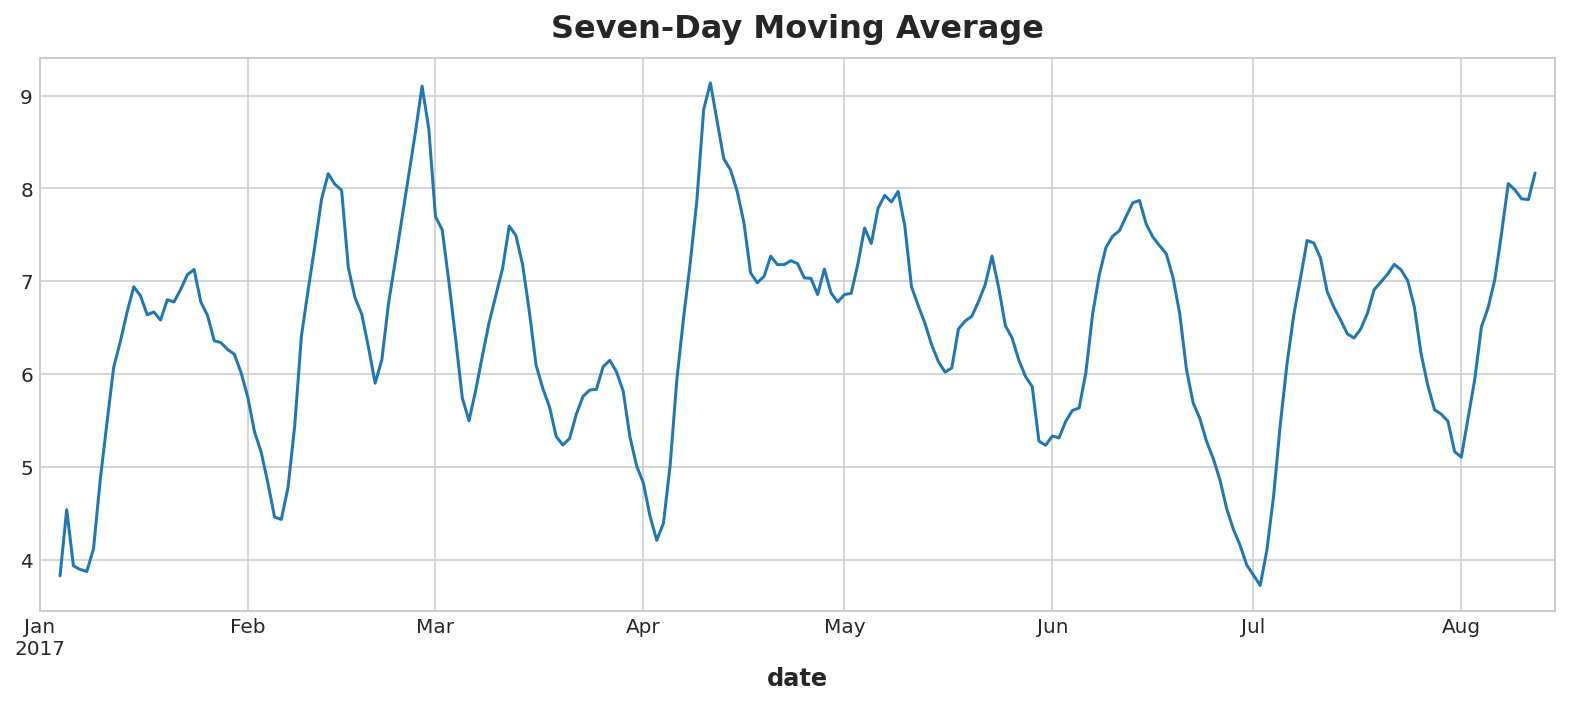

In [80]:
y_ma = y.rolling(7, center=True).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

###### Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

###### --------------------------------------------------------------------------------------------------------------------------------------------------------------

###### Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

In [86]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, leads=None, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

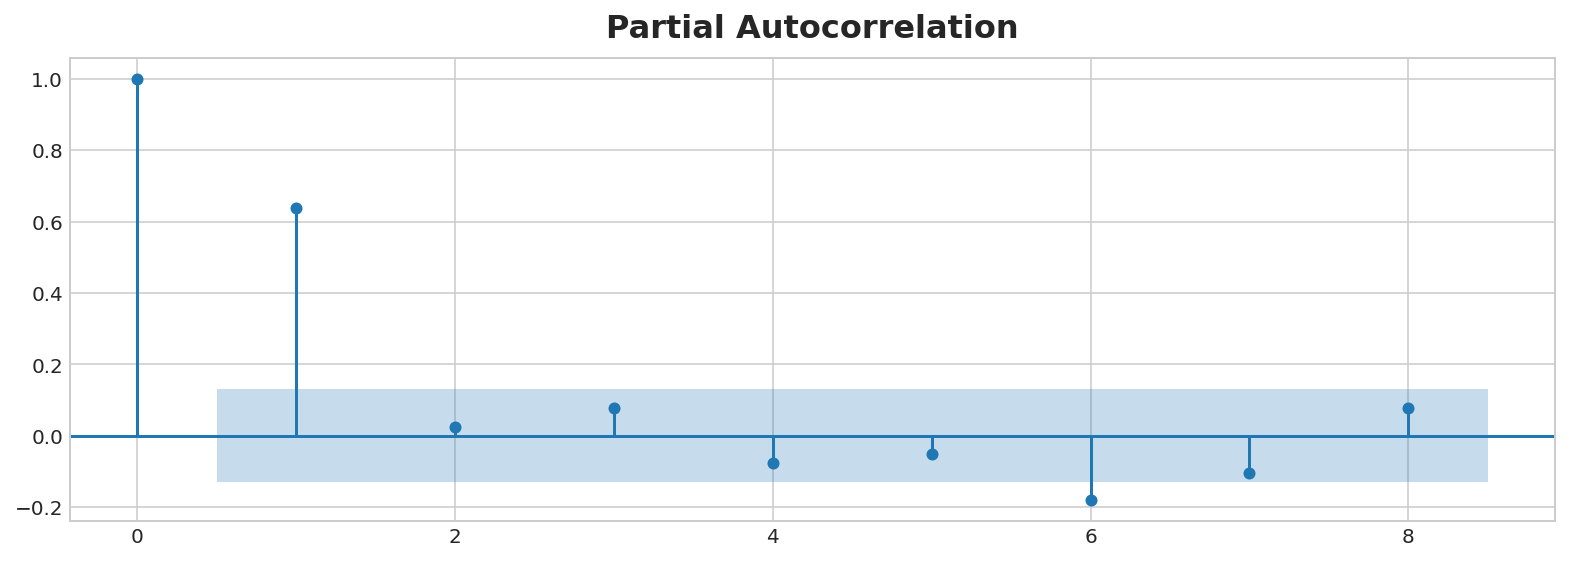

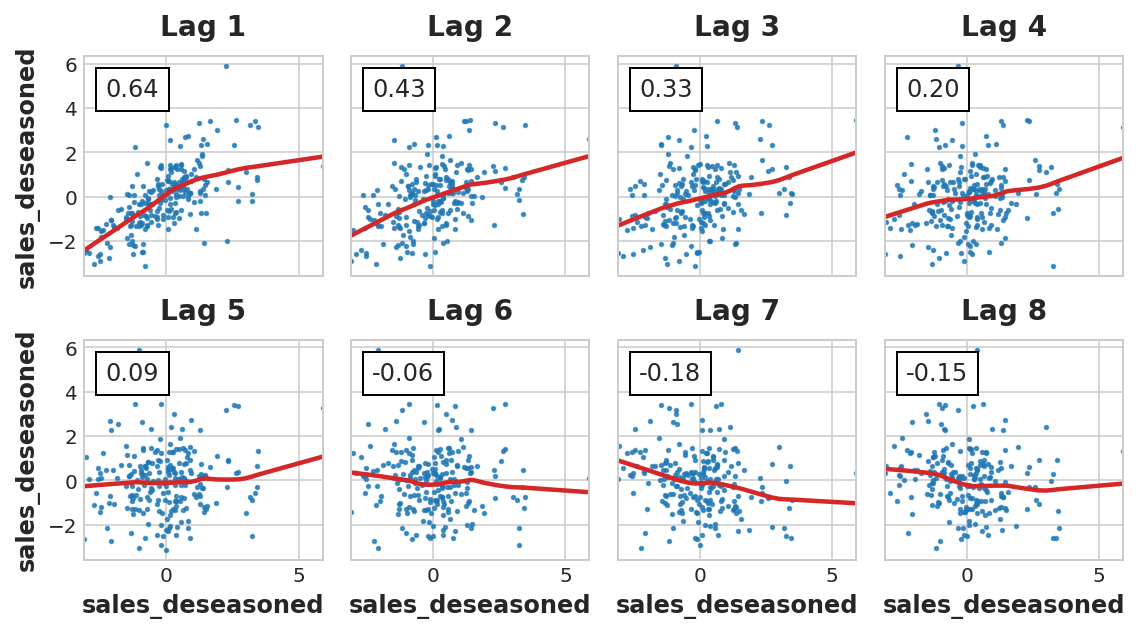

In [83]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

##### The correlogram indicates the first lag is likely to be significant, as well as possibly the sixth lag. The lag plot suggests some non-linear effect as well.

-------------------------------------------------------------------------------

###### Recall from the tutorial that a *leading indicator* is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

###### The competition dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

###### Examine leading and lagging values for `onpromotion` plotted against magazine sales.

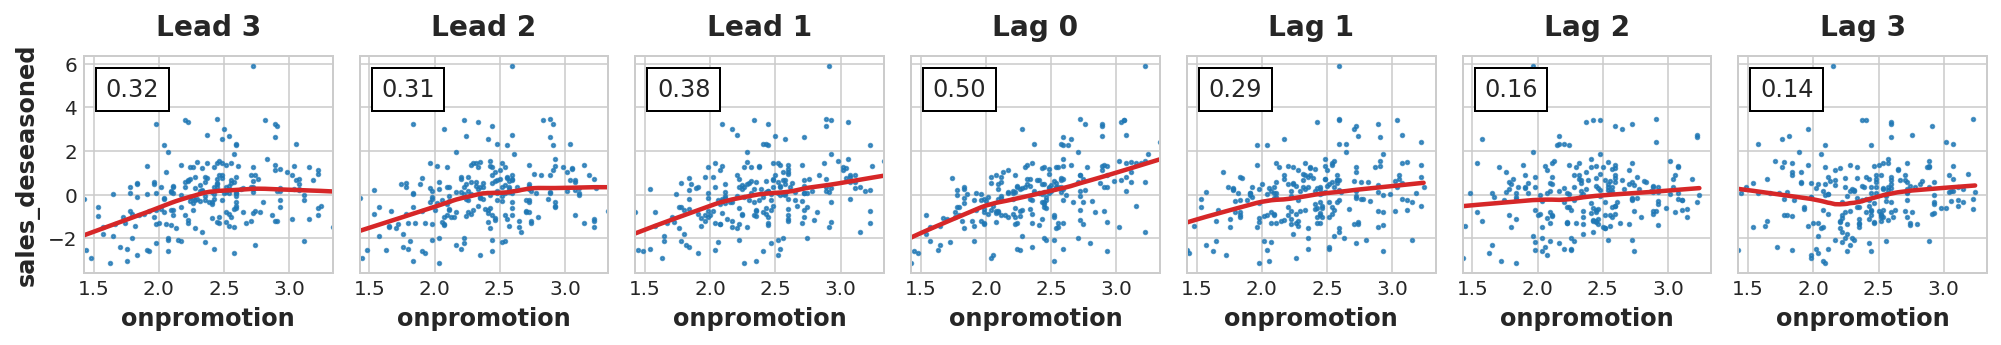

In [89]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, leads=3, nrows=1);

#### Examine time series features

###### Does it appear that either leading or lagging values of `onpromotion` could be useful as a feature?

###### The lag plot indicates that both leading and lagged values of onpromotion are correlated with magazine sales. This suggests that both kinds of values could be useful as features.

###### In addition, the leading values seem to have some non-linear effect.

#### Create time series features

###### Create the features indicated in the solution to Question 3. If no features from that series would be useful, use an empty dataframe `pd.DataFrame()` as your answer.

In [90]:
# Make features from `y_deseason`
X_lags = make_lags(y_deseason, lags=1)

# Make features from `onpromotion`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

# Make features from `oil`
X_oil = pd.DataFrame()

X = pd.concat([X_time, X_lags, X_promo, X_oil], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.11025
Validation RMSLE: 0.10031


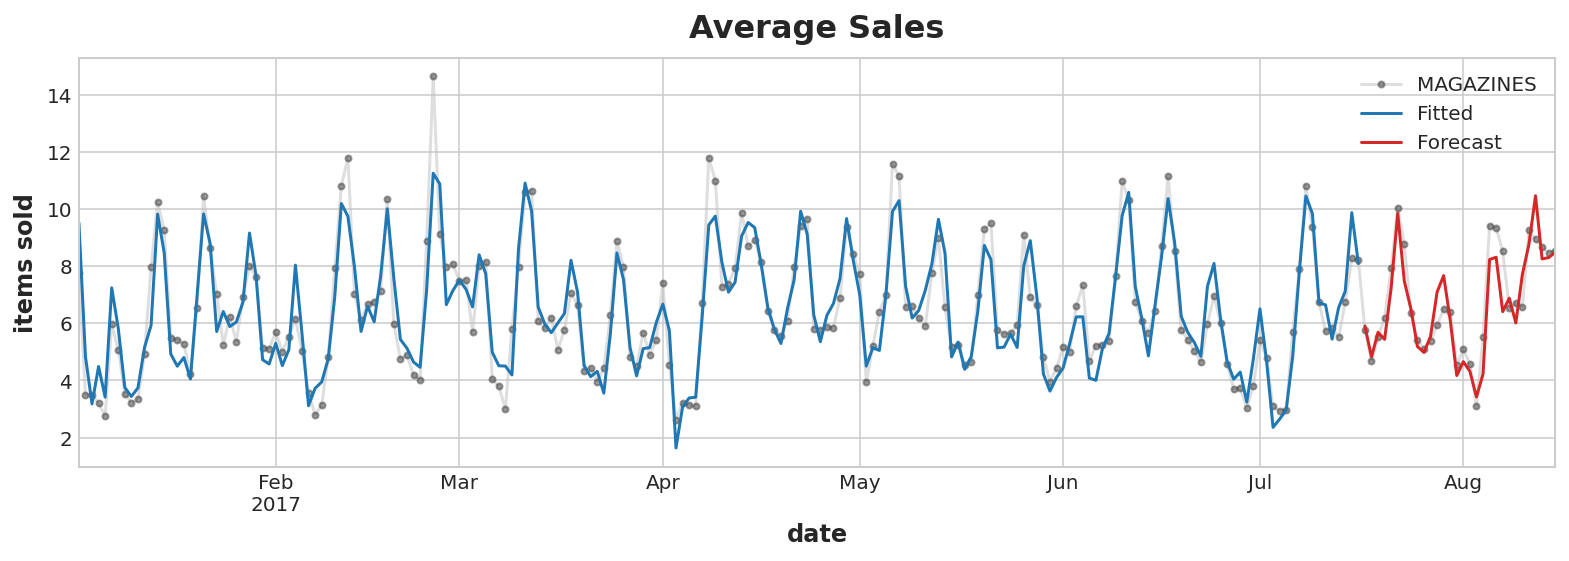

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

###### -------------------------------------------------------------------------------

###### Including moving averages and other rolling statistics in feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

###### Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the `rolling` method. Second, the target should be lagged a step.

#### Create statistical features
###### create the following features:
###### - 14-day rolling median (`median`) of lagged target
###### - 7-day rolling standard deviation (`std`) of lagged target
###### - 7-day sum (`sum`) of items "on promotion", with centered window

In [92]:
y_lag = mag_sales.loc[:, 'sales'].shift(1)
onpromo = mag_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(7, center=True).sum()

##### Check out the Pandas [`Window` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/window.html) for more statistics you can compute. Also try "exponential weighted" windows by using `ewm` in place of `rolling`; exponential decay is often a more realistic representation of how effects propagate over time.

## Hybrid Models
#### Combine the strengths of two forecasters with this powerful technique.
###### Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. In this lesson, we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

#### Components and Residuals
###### So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've studied up to now three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random error: series = trend + seasons + cycles + error. Each of the terms in this model we would then call a component of the time series.The residuals of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.The difference between the target series and the predictions (blue) gives the series of residuals. Subtracting out the fitted curve leaves the residuals, on the right. The residuals contain everything the trend-seasonal model didn't learn.

###### We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended residuals and subtract the seasons out, then learn the cycles and subtract the cycles out, and finally only the unpredictable error remains.Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

#### Hybrid Forecasting with Residuals
###### We used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

###### In detail, the process is this:

In [ ]:
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

##### We'll usually want to use different feature sets (X_train_1 and X_train_2 above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example. While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

#### Designing Hybrids
###### There are many ways you could combine machine learning models besides the way we've outlined in this lesson. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind. Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind. The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends. A decision tree will fail to extrapolate a trend beyond the training set. This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these boosted hybrids; the method of using predictions as features is known as "stacking", so we will call these stacked hybrids.

##### For inspiration, here are a few top scoring solutions examples:

[STL boosted with exponential smoothing - Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125)
__________________________________________________________________________________________________________________________________________________________________________________
[ARIMA and exponential smoothing boosted with GBDT - Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales/discussion/17896)
__________________________________________________________________________________________________________________________________________________________________________________
[An ensemble of stacked and boosted hybrids - Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395)
__________________________________________________________________________________________________________________________________________________________________________________
[Exponential smoothing stacked with LSTM neural net - M4](https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf)

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [94]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex5 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

###### Create a boosted hybrid for the *Store Sales* dataset by implementing a new Python class. Add `fit` and `predict` methods to give it a scikit-learn like interface.

In [95]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

#### Define fit method for boosted hybrid
###### Complete the fit definition for the BoostedHybrid class.

In [96]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

####  Define predict method for boosted hybrid

###### Now define the `predict` method for the `BoostedHybrid` class. Refer back to step 3 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [97]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [98]:
# Target series
y = family_sales.loc[:, 'sales']

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

#### Train boosted hybrid

###### Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [99]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

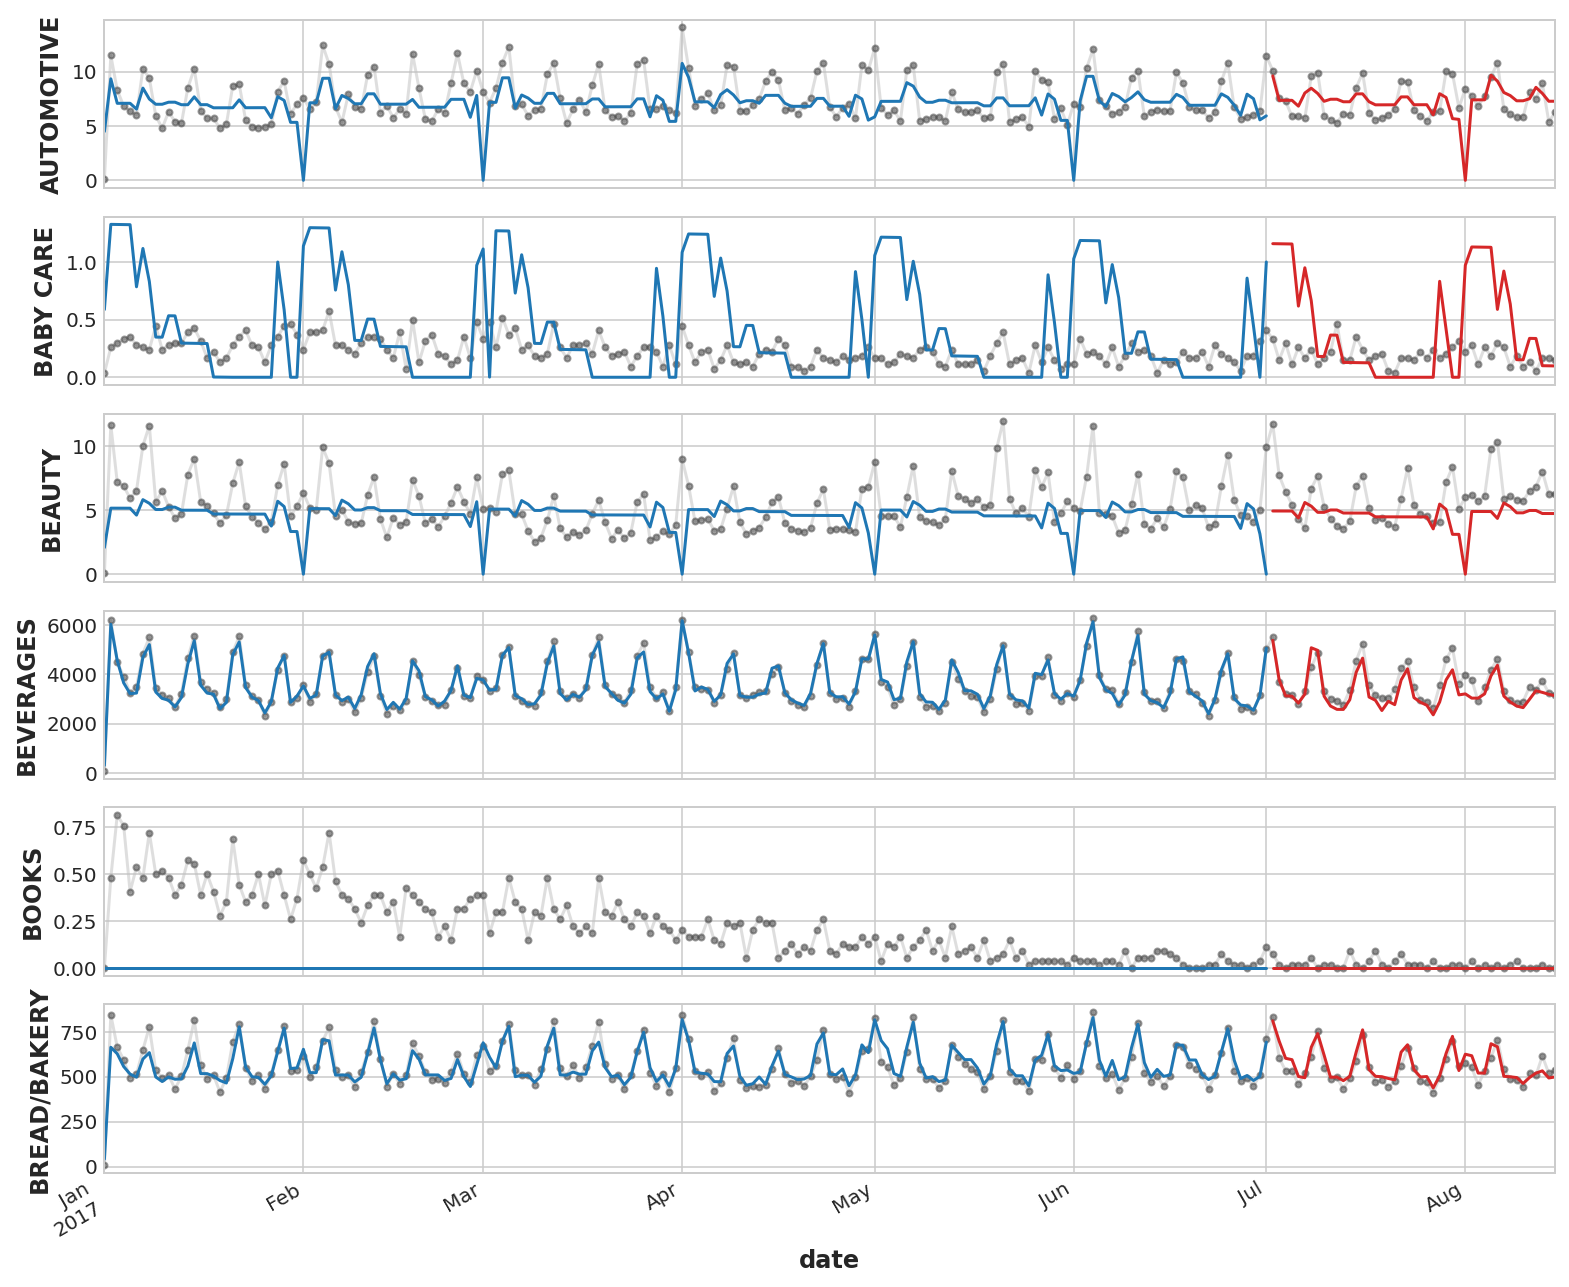

In [100]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

#### Fit with different learning algorithms
###### Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous questions.

In [101]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [102]:
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

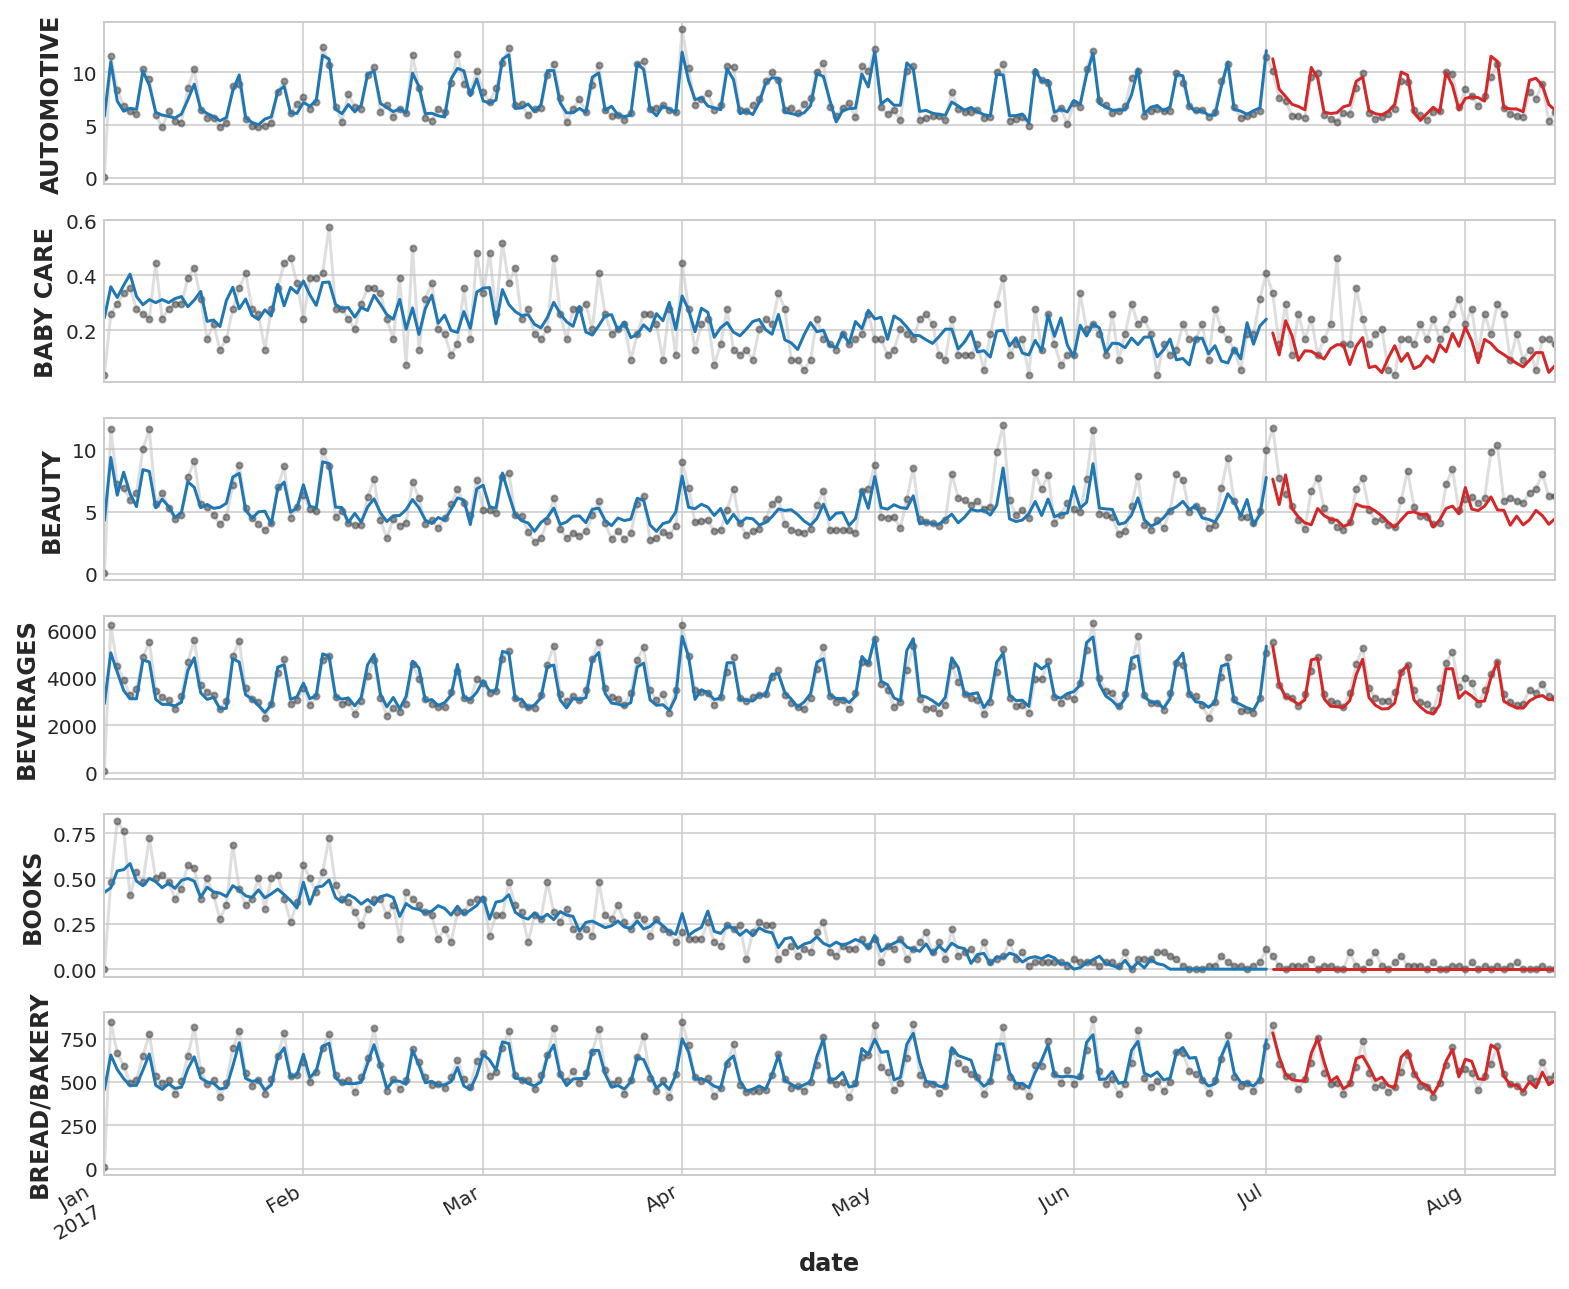

In [103]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

#### Forecasting With Machine Learning

##### Defining the Forecasting Task
###### There are two things to establish before designing a forecasting model:
###### what information is available at the time a forecast is made (features), and,
###### the time period during which you require forecasted values (target).
###### The forecast origin is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features. The forecast horizon is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

##### Preparing Data for Forecasting
###### In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless, of course, you are only using deterministic features like trend and seasonality.)
###### Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [104]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

##### The above illustrates how a dataset would be prepared similar to the Defining a Forecast figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is y_step_1. The missing values we could either fill-in or drop.

#### Multistep Forecasting Strategies
###### There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

#### Multioutput model
###### Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.


#### Direct strategy
###### Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.


#### Recursive strategy
###### Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.


#### DirRec strategy
###### A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

##### defines a helper function plot_multistep

In [105]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [107]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
# from learntools.time_series.style import *  # plot style settings
# from learntools.time_series.utils import (create_multistep_example,
#                                           load_multistep_data,
#                                           make_lags,
#                                           make_multistep_target,
#                                           plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

data_dir = Path('/rapids/notebooks/my_code/TimeSeries')
comp_dir = Path('/rapids/notebooks/my_code/TimeSeries')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

###### -------------------------------------------------------------------------------
###### Consider the following three forecasting tasks:

###### a. 3-step forecast using 4 lag features with a 2-step lead time<br>
###### b. 1-step forecast using 3 lag features with a 1-step lead time<br>
###### c. 3-step forecast using 4 lag features with a 1-step lead time<br>


In [108]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

#### Match description to dataset
###### The number of forecasting steps is the number of columns under Targets. The number of lags is the number of columns under Features. The lead time is the smallest lag step possible.
###### task_a = Dataset 2
###### task_b = Dataset 1
###### task_c = Dataset 3

In [109]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            4
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            3
                     2017-08-14  17.000000            2
                     2017-08-15  16.000000            2

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888           20
                     2017-08

#### Identify the forecasting task for *Store Sales* competition

##### Try to identify the *forecast origin* and the *forecast horizon*. How many steps are within the forecast horizon? What is the lead time for the forecast?

##### The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

##### Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.

#### Create multistep dataset for *Store Sales*

###### Create targets suitable for the *Store Sales* forecasting task. Use 4 days of lag features. Drop any missing values from both targets and features.

In [110]:
y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()

y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [111]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

#### Forecast with the DirRec strategy

###### Instatiate a model that applies the DirRec strategy to XGBoost.

In [112]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(base_estimator=XGBRegressor())

In [113]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

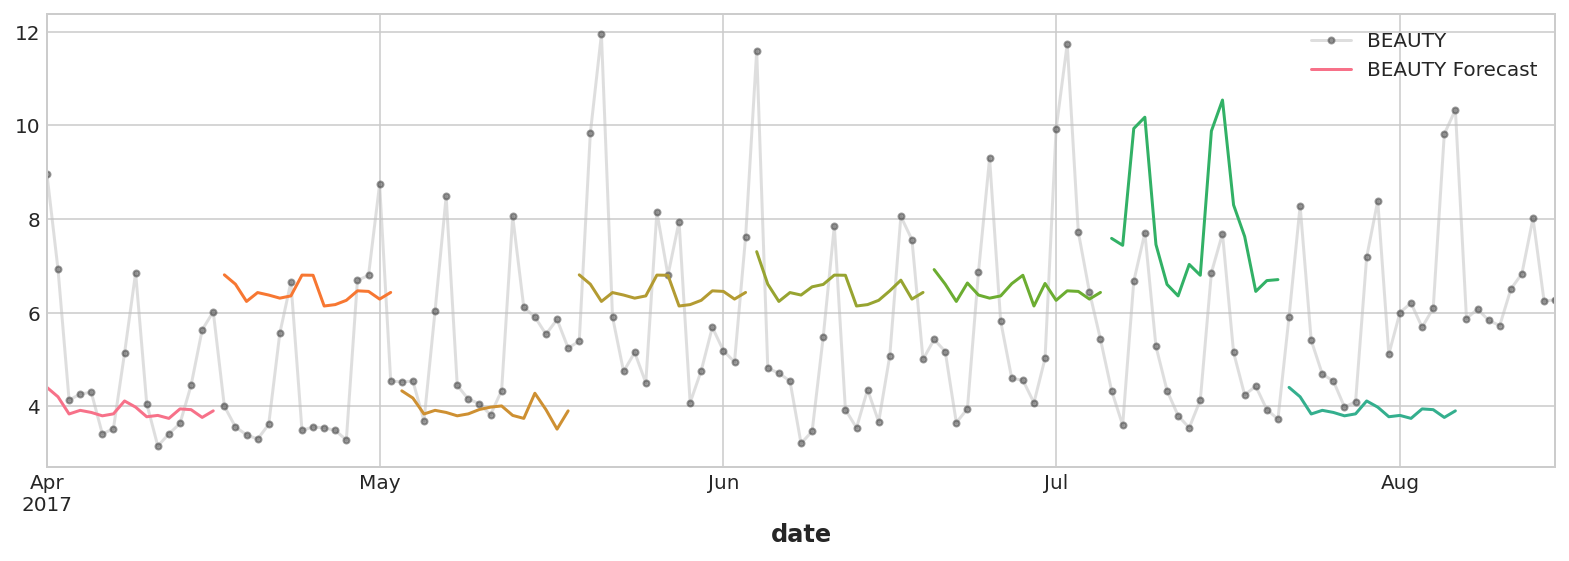

In [114]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

### References #

- *Learnings from Kaggle's forecasting competitions*, an article by Casper Solheim Bojer and Jens Peder Meldgaard.
- *Forecasting: Principles and Practice*, a book by Rob J Hyndmann and George Athanasopoulos.
- *Practical Time Series Forecasting with R*, a book by Galit Shmueli and Kenneth C. Lichtendahl Jr.
- *Time Series Analysis and Its Applications*, a book by Robert H. Shumway and David S. Stoffer.
- *Machine learning strategies for time series forecasting*, an article by Gianluca Bontempi, Souhaib Ben Taieb, and Yann-Aël Le Borgne.
- *On the use of cross-validation for time series predictor evaluation*, an article by Christoph Bergmeir and José M. Benítez.


##### For inspiration, here are a few top scoring solutions examples:

- [**Seasonal adjustment - COVID-19 cases**](http://www.chadfulton.com/topics/002-seasonal-adjustment.html)
- [**learntools**](https://github.com/Kaggle/learntools/tree/master/notebooks)
- [**STL boosted with exponential smoothing - Walmart Recruiting - Store Sales Forecasting**](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125)
- [**ARIMA and exponential smoothing boosted with GBDT - Rossmann Store Sales**](https://www.kaggle.com/c/rossmann-store-sales/discussion/17896)
- [**An ensemble of stacked and boosted hybrids - Web Traffic Time Series Forecasting**](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395)
- [**Exponential smoothing stacked with LSTM neural net - M4**](https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf)
- [**Corporación Favorita**](https://www.kaggle.com/c/favorita-grocery-sales-forecasting)
- [**Rossmann Store Sales**](https://www.kaggle.com/c/rossmann-store-sales)
- [**Wikipedia Web Traffic**](https://www.kaggle.com/c/web-traffic-time-series-forecasting/)
- [**Walmart Store Sales**](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)
- [**Walmart Sales in Stormy Weather**](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)
- [**M5 Forecasting - Accuracy**](https://www.kaggle.com/c/m5-forecasting-accuracy)
